In [1]:
from models import Models
import numpy as np
import random
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os
import cv2
import itertools
%load_ext autoreload
%autoreload 2 

%matplotlib inline

Using TensorFlow backend.


In [2]:
class Dataset:
      
    def __init__(self, path, img_w, img_h, n_labels):
        self.path = path
        self.img_w = img_w
        self.img_h = img_h
        self.n_labels = n_labels
        self.data_shape = self.img_w * self.img_h
    
    def probability_augmentation(self, prob):
        random_prob=random.random()
        if(random_prob>prob):
            return False
        else:
            return True
        
    def invert_img(self, image, label):
        invert=iaa.Invert(1, per_channel=True)
        inverted_img=invert.augment_image(image)

        return inverted_img, label

    def sigmoid_cont_img(self, image, label, gain_max, gain_min, cutoff_max, cutoff_min):
        gain= random.uniform(gain_max, gain_min)
        cutoff= random.uniform(cutoff_max, cutoff_min)
        sigmoid_cont= iaa.SigmoidContrast(gain=gain, cutoff=cutoff)

        image = sigmoid_cont.augment_image(image)

        return image, label

    def shear(self, image, annotation, mins, maxs, step=1):
        angle=random.randrange(mins,maxs,step=step)
        shear=iaa.Affine(shear=angle)
        image_shear=shear.augment_image(image)
        annotation_shear=shear.augment_image(annotation)
        image_shear,annotation_shear=self.crop_from_center(image_shear,annotation_shear, 3, 3)
        
        return image_shear, annotation_shear

    def hue_saturation(self, image, annotation, minhs, maxhs):
        hue_sat=iaa.AddToHueAndSaturation((minhs, maxhs))
        image_hue_sat=hue_sat.augment_image(image)
        
        return image_hue_sat,annotation

    def brightness(self, image, annotation, min_b, max_b):
        brightness=iaa.Add(value=(min_b, max_b),per_channel=0)
        image_brightness=brightness.augment_image(image)
        
        return image_brightness,annotation 

    def motionblur(self, image, annotation, min_angle, max_angle, step=1):
        angle=random.randrange(min_angle,max_angle,step=step)
        motionblur=iaa.blur.MotionBlur(k=10, angle=angle)
        image_motion_blur=motionblur.augment_image(image)
        annotation_motion_blur=motionblur.augment_image(annotation)
        
        return image_motion_blur, annotation_motion_blur

    def resize_image(self, image, annotation, img_w, img_h):
        image = cv2.resize(image,(img_w,img_h))
        annotation = cv2.resize(annotation,(img_w,img_h))
        
        return image,annotation

    def crop_from_center(self, image, annotation, h_crop, w_crop):
        h,w,d=image.shape
        image_crop = image[int((h/2)-(h/h_crop)):int((h/2)+(h/h_crop)), int((w/2)-(w/w_crop)):int((w/2)+(w/w_crop))]
        annotation_crop = annotation[int((h/2)-(h/h_crop)):int((h/2)+(h/h_crop)), int((w/2)-(w/w_crop)):int((w/2)+(w/w_crop))]
        
        return image_crop, annotation_crop

    def zoom(self, image, annotation, min_zoom, max_zoom):
        zoom=random.uniform(min_zoom,max_zoom)
        rotation = iaa.Affine(scale=zoom,mode="symmetric")
        image_zoomed = rotation.augment_image(image)
        annotation_zoomed = rotation.augment_image(annotation)
        image_zoomed,annotation_zoomed=self.crop_from_center(image_zoomed,annotation_zoomed, 3, 3)
        
        return image_zoomed,annotation_zoomed

    def horizontal_flip(self, image, annotation):
        horizontal_flip = iaa.Fliplr(1.0)
        image = horizontal_flip.augment_image(image)
        annotation = horizontal_flip.augment_image(annotation)  
        
        return image,annotation

    def random_rotation(self, image, annotation, min_angle, max_angle, step=1):
        angle=random.randrange(min_angle,max_angle,step=step)
        rotation = iaa.Affine(scale=1,rotate=angle,mode="symmetric")
        image_rotated = rotation.augment_image(image)
        annotation_rotated = rotation.augment_image(annotation)
        image_rotated,annotation_rotated=self.crop_from_center(image_rotated,annotation_rotated, 3, 3)
        
        return image_rotated,annotation_rotated

    def binarylab(self, labels):
        x = np.zeros([img_h,img_w,n_labels])  

        for i in range(img_h):
            for j in range(img_w):
                x[i,j,labels[i][j]]=1
        return x

    def binarylab(self, labels):           ####### NO SE QUE HACE ESTO
        x = np.zeros([img_h,img_w,n_labels])  

        for i in range(img_h):
            for j in range(img_w):
                x[i,j,labels[i][j]]=1
        return x

    def visualize_annotation(self, temp, plot=False):
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0,5):
            r[temp==l]=label_colours[l,0]
            g[temp==l]=label_colours[l,1]
            b[temp==l]=label_colours[l,2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3), dtype=np.uint8)
        rgb[:,:,0] = (b)#[:,:,0]
        rgb[:,:,1] = (g)#[:,:,1]
        rgb[:,:,2] = (r)#[:,:,2]
        if plot:
            plt.imshow(rgb)
        else:
            return rgb

    def load_image(self, name):
        bgr=cv2.imread(name)
        print(type(bgr))
        rgb=cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB) ###### ESTO FALLABA XQ la img de enrtaga es de 64b
        return rgb

    def crop_center_image(self, image, annotation, img_w, img_h, augmentation=True):
        h,w,d=image.shape
        images=[]
        labels=[]
        number_of_crop=int(w/img_w)
        for j in range(number_of_crop):
            image_crop = image[int((h/2)-(img_h/2)):int((h/2)+(img_h/2)),int((j*img_w)):int((j+1)*img_w)]
            annotation_crop = annotation[int((h/2)-(img_h/2)):int((h/2)+(img_h/2)),int((j*img_w)):int((j+1)*img_w)]
            images.append(image_crop) 
            labels.append(annotation_crop)
        return images,labels
  
    @staticmethod
    def plot_image(image):
        image=image*255
        plt.imshow(image.astype(np.uint8))
        plt.show()
        
    @staticmethod
    def plot_binary_image(image):
        image=image*255
        binary_img = np.squeeze(image, axis=2)
        plt.imshow(binary_img)
        plt.show()
    
    def add_image(self, images, labels, image2add, label2add, img_w, img_h):
        image2add, label2add=self.resize_image(image2add, label2add, img_w, img_h)
        
        image2add = image2add/255.0
        
        images.append(image2add)
        labels.append(label2add)
        
        return images, labels
    
    def display_data_augmentation(self, imgs, w_n_imgs, h_n_imgs, margin_x, margin_y):
        w = w_n_imgs # Width of the matrix (nb of images)
        h = h_n_imgs # Height of the matrix (nb of images)
        n = w*h
        
        #Define the shape of the image to be replicated (all images should have the same shape)
        img_h, img_w, img_c = imgs[0].shape

        #Define the margins in x and y directions
        m_x = margin_x
        m_y = margin_y

        #Size of the full size image
        mat_x = img_w * w + m_x * (w - 1)
        mat_y = img_h * h + m_y * (h - 1)

        #Create a matrix of zeros of the right size and fill with 255 (so margins end up white)
        imgmatrix = np.zeros((mat_y, mat_x, img_c),np.uint8)
        imgmatrix.fill(255)

        #Prepare an iterable with the right dimensions
        positions = itertools.product(range(h), range(w))

        for (y_i, x_i), img in zip(positions, imgs):
            x = x_i * (img_w + m_x)
            y = y_i * (img_h + m_y)
            imgmatrix[y:y+img_h, x:x+img_w, :] = (img)
            
        return imgmatrix
    
    
    def single_image_augmentation(self, image_name, annotation_name):
        
        images=[]
        labels=[]
        
        print(os.getcwd() + "/" + self.path + image_name + "  -  ", end="")
        image = self.load_image(os.getcwd() + "/" + self.path + image_name)
        print(os.getcwd() + "/" + self.path + annotation_name)
        annotation = self.load_image(os.getcwd() + "/" + self.path + annotation_name)
        self.add_image(images, labels, image, annotation, self.img_w, self.img_h)

        images_crop_center, annotations_crop_center = self.crop_center_image(image,annotation, self.img_w, self.img_h)
        for image_crop_center, annotation_crop_center in zip(images_crop_center, annotations_crop_center):
            self.add_image(images, labels, image_crop_center, annotation_crop_center, self.img_w, self.img_h)
        
        image_horizontal_flip, annotation_horizontal_flip = self.horizontal_flip(image,annotation)
        self.add_image(images, labels, image_horizontal_flip, annotation_horizontal_flip, self.img_w, self.img_h)
        
        image_rotated,annotation_rotated = self.random_rotation(image,annotation, -10, 10)
        self.add_image(images, labels, image_rotated, annotation_rotated, self.img_w, self.img_h)
        
        image_zoomed, annotation_zoomed = self.zoom(image, annotation, 0.6, 1.2)
        self.add_image(images, labels, image_zoomed, annotation_zoomed, self.img_w, self.img_h)
        
        image_motion_blur, annotation_motion_blur = self.motionblur(image, annotation, 160, 360)
        self.add_image(images, labels, image_motion_blur, annotation_motion_blur, self.img_w, self.img_h)
        
        image_bright, annotation_bright = self.brightness(image, annotation,-50,+50)
        self.add_image(images, labels, image_bright, annotation_bright, self.img_w, self.img_h)
        
        image_huesat, annotation_huesat = self.hue_saturation(image, annotation, -30, +30)
        self.add_image(images, labels, image_huesat, annotation_huesat, self.img_w, self.img_h)
        
        image_shear, annotation_shear = self.shear(image, annotation, -50, +50)
        self.add_image(images, labels, image_shear, annotation_shear, self.img_w, self.img_h)
        
        inverted_img, inverted_label = self.invert_img(image, annotation)
        self.add_image(images, labels, inverted_img, inverted_label, self.img_w, self.img_h)
        
        sigmoid_img, sigmoid_label = self.sigmoid_cont_img(image, annotation, 9.0, 11.0, 0.0, 0.70)
        self.add_image(images, labels, sigmoid_img, sigmoid_label, self.img_w, self.img_h)
                    
        images = np.array(images)
        labels = np.array(labels)
        labels = labels[:,:,:,0:1]
            
        return images, labels
   
    def createDataset(self, augmentation=False, prob1=False):
        
        images=[]
        labels=[]
        
        with open(self.path+'data.txt') as f:
            txt = map(str.rstrip, f.readlines())
            txt = [line.split(' ') for line in txt]
        for i in range(len(txt)):
            
            fotoO = mpimg.imread(os.getcwd() + "/" + self.path + txt[i][0])
            fotoM = mpimg.imread(os.getcwd() + "/"  + self.path + txt[i][1])
            plt.imshow(fotoO)
            plt.imshow(fotoM)
            print(os.getcwd() + "/" + self.path + txt[i][0] + "  -  ", end="")
            image = self.load_image(os.getcwd() + "/" + self.path + txt[i][0])
            print(os.getcwd() + "/" + self.path + txt[i][1])
            annotation = self.load_image(os.getcwd() + "/" + self.path + txt[i][1])
            self.add_image(images, labels, image, annotation, self.img_w, self.img_h)
            if augmentation:
                
                images_crop_center, annotations_crop_center = self.crop_center_image(image,annotation, self.img_w, self.img_h)
                for image_crop_center, annotation_crop_center in zip(images_crop_center, annotations_crop_center):
                    self.add_image(images, labels, image_crop_center, annotation_crop_center, self.img_w, self.img_h)
                image_horizontal_flip, annotation_horizontal_flip = self.horizontal_flip(image,annotation)
                self.add_image(images, labels, image_horizontal_flip, annotation_horizontal_flip, self.img_w, self.img_h)
                if prob1 or self.probability_augmentation(0.8):
                    image_rotated,annotation_rotated = self.random_rotation(image,annotation, -10, 10)
                    self.add_image(images, labels, image_rotated, annotation_rotated, self.img_w, self.img_h)
                if prob1 or self.probability_augmentation(0.8):
                    image_zoomed, annotation_zoomed = self.zoom(image, annotation, 0.6, 1.2)
                    self.add_image(images, labels, image_zoomed, annotation_zoomed, self.img_w, self.img_h)
                if prob1 or self.probability_augmentation(0.6):
                    image_motion_blur, annotation_motion_blur = self.motionblur(image, annotation, 160, 360)
                    self.add_image(images, labels, image_motion_blur, annotation_motion_blur, self.img_w, self.img_h)
                if prob1 or self.probability_augmentation(0.6):
                    image_bright, annotation_bright = self.brightness(image, annotation,-50,+50)
                    self.add_image(images, labels, image_bright, annotation_bright, self.img_w, self.img_h)
                if prob1 or self.probability_augmentation(0.6):
                    image_huesat, annotation_huesat = self.hue_saturation(image, annotation, -20, +20)
                    self.add_image(images, labels, image_huesat, annotation_huesat, self.img_w, self.img_h)
                if prob1 or self.probability_augmentation(0.6):
                    image_shear, annotation_shear = self.shear(image, annotation, -20, +20)
                    self.add_image(images, labels, image_shear, annotation_shear, self.img_w, self.img_h)
                if prob1 or self.probability_augmentation(0.6):
                    inverted_img, inverted_label = self.invert_img(image, annotation)
                    self.add_image(images, labels, inverted_img, inverted_label, self.img_w, self.img_h)
                if prob1 or self.probability_augmentation(0.6):
                    sigmoid_img, sigmoid_label = self.sigmoid_cont_img(image, annotation, 9.0, 11.0, 0.0, 0.70)
                    self.add_image(images, labels, sigmoid_img, sigmoid_label, self.img_w, self.img_h)
                    
        images = np.array(images)
        labels = np.array(labels)
        labels = labels[:,:,:,0:1]
            
        return images, labels
        

/home/naoki/Documents/LSD/PINV15177/Training/1.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/1-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/2.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/2-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/3.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/3-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/4.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/4-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/5.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/5-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/6.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/6-annotation.png
<class 'numpy.ndarray'>
/home/naok

/home/naoki/Documents/LSD/PINV15177/Training/54.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/54-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/55.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/55-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/56.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/56-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/57.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/57-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/58.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/58-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/59.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/59-annotation.png
<class 'numpy.ndarray'

/home/naoki/Documents/LSD/PINV15177/Training/107.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/107-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/108.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/108-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/109.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/109-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/110.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/110-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/111.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/111-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/112.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/112-annotation.png
<class 'nu

/home/naoki/Documents/LSD/PINV15177/Training/156.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/156-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/157.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/157-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/158.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/158-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/159.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/159-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/160.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/160-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/161.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/161-annotation.png
<class 'nu

/home/naoki/Documents/LSD/PINV15177/Training/ter1_111.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_111-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_112.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_112-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_114.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_114-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_115.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_115-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_116.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_116-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_117.png  -  <class 'numpy.ndarray'>
/home/naoki/Documen

/home/naoki/Documents/LSD/PINV15177/Training/ter1_29.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_29-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_30.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_30-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_31.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_31-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_32.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_32-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_34.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_34-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_35.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV

/home/naoki/Documents/LSD/PINV15177/Training/ter1_82.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_82-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_84.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_84-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_85.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_85-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_86.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_86-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_87.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_87-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Training/ter1_89.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV

/home/naoki/Documents/LSD/PINV15177/Validation/15.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Validation/15-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Validation/16.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Validation/16-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Validation/17.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Validation/17-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Validation/18.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Validation/18-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Validation/19.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Validation/19-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Validation/20.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Validation/20-annotation.pn

/home/naoki/Documents/LSD/PINV15177/Validation/ter1_63.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Validation/ter1_63-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Validation/ter1_68.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Validation/ter1_68-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Validation/ter1_73.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Validation/ter1_73-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Validation/ter1_78.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Validation/ter1_78-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Validation/ter1_8.png  -  <class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Validation/ter1_8-annotation.png
<class 'numpy.ndarray'>
/home/naoki/Documents/LSD/PINV15177/Validation/ter1_83.png  -  <class 'numpy.ndarray'>
/home/naok

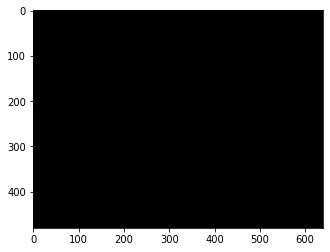

In [3]:
path = 'Training/'
path_val = 'Validation/'
img_w = 160
img_h = 160
n_labels = 2 #6
model_base_name = 'unet160--'

dataset = Dataset(path, img_w, img_h, n_labels)
x, y = dataset.createDataset(augmentation=True, prob1=False)

dataset = Dataset(path_val, img_w, img_h, n_labels)
x_val, y_val = dataset.createDataset(augmentation=False, prob1=False)

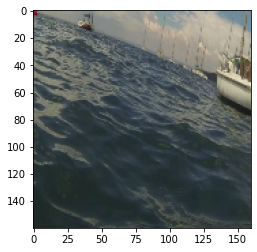

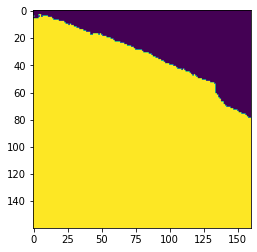

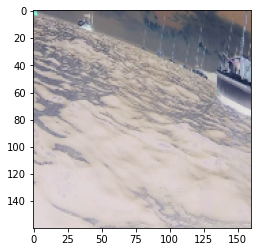

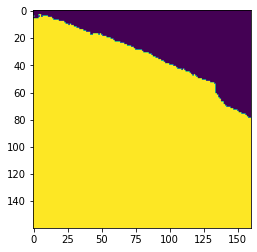

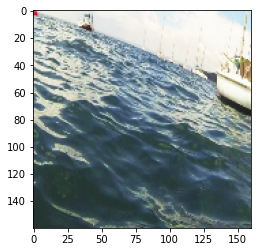

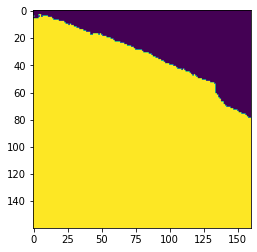

In [4]:
from imgaug import augmenters as iaa
import random



image=x[10]
label=y[10]

# Graficas de prueba
dataset.plot_image(image)
dataset.plot_binary_image(label)

def invert_img(image, label):
    invert=iaa.Invert(1, per_channel=True)
    inverted_img=invert.augment_image(image)
    
    return inverted_img, label

def sigmoid_cont_img(image, label, gain_max, gain_min, cutoff_max, cutoff_min):
    gain= random.uniform(gain_max, gain_min)
    cutoff= random.uniform(cutoff_max, cutoff_min)
    sigmoid_cont= iaa.SigmoidContrast(gain=gain, cutoff=cutoff)
    
    image = sigmoid_cont.augment_image(image)
    
    return image, label

inverted_img, inverted_label = invert_img(image, label)
sigmoid_img, sigmoid_label = sigmoid_cont_img(image, label, 9.0, 11.0, 0.0, 0.70)



dataset.plot_image(inverted_img)
dataset.plot_binary_image(inverted_label)
dataset.plot_image(sigmoid_img)
dataset.plot_binary_image(sigmoid_label)

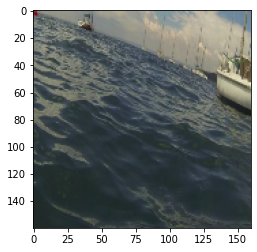

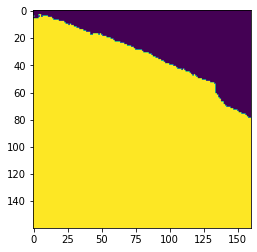

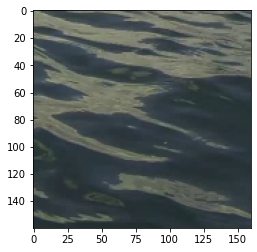

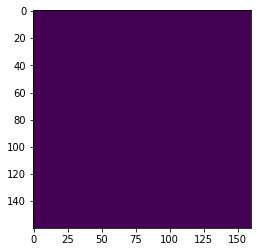

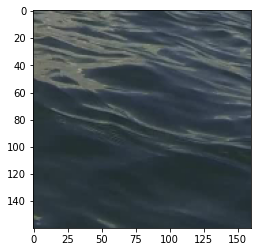

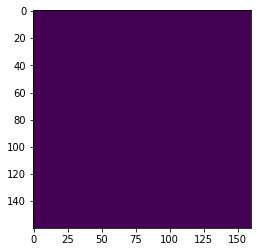

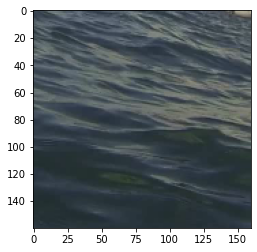

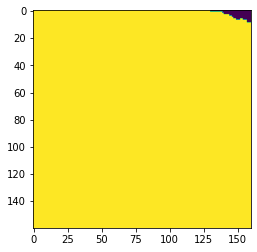

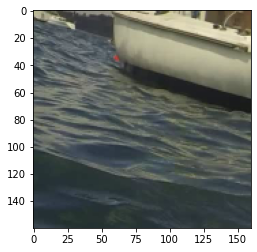

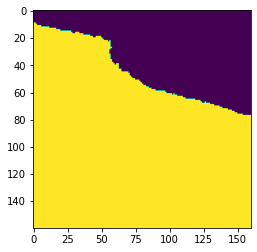

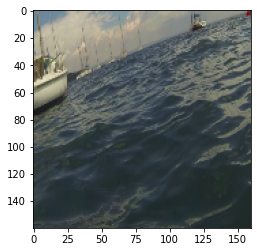

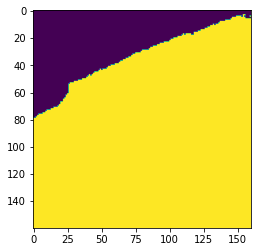

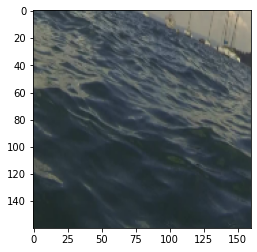

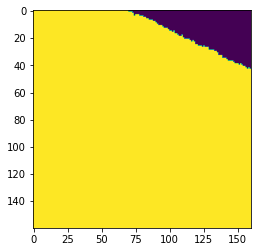

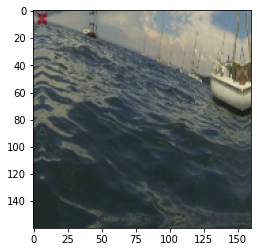

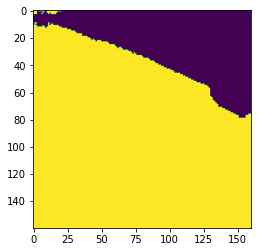

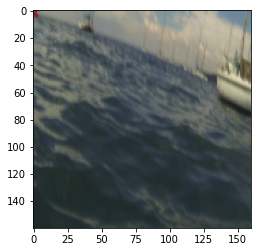

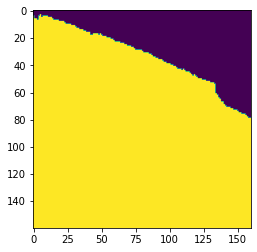

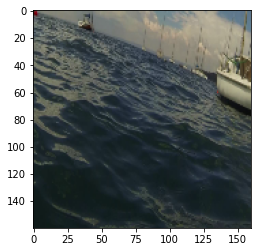

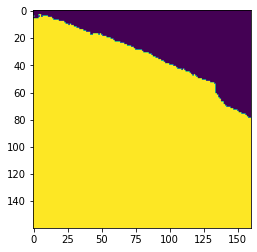

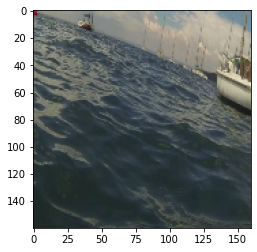

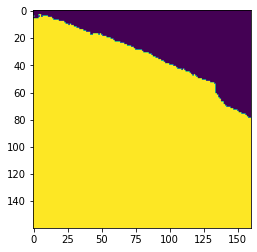

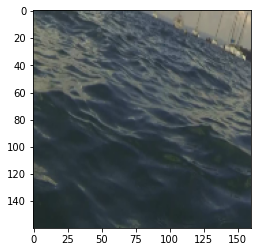

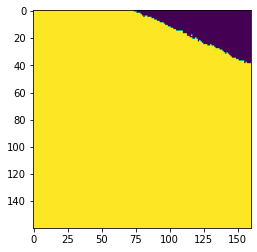

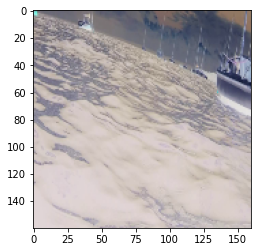

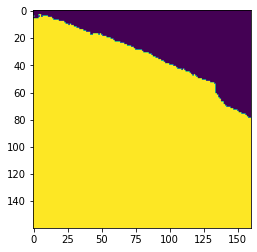

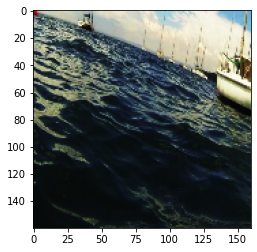

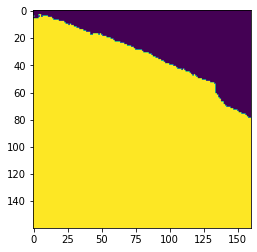

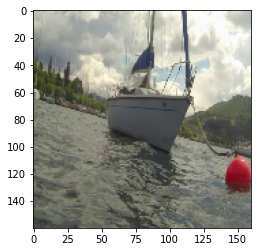

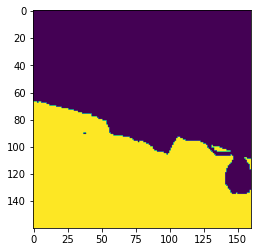

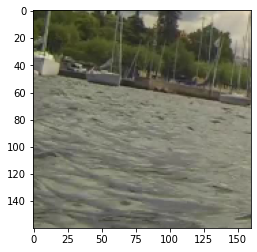

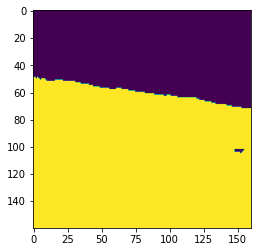

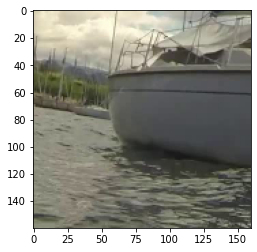

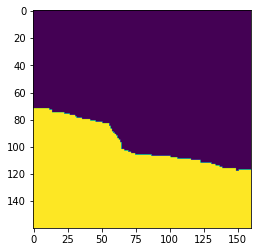

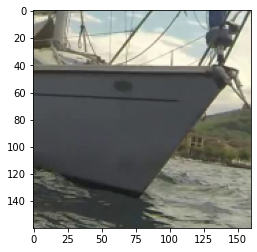

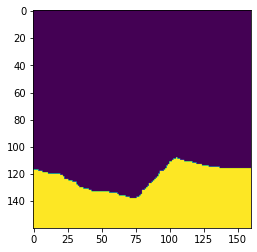

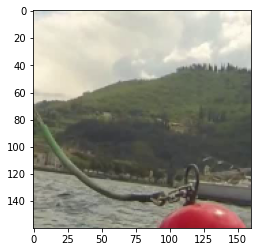

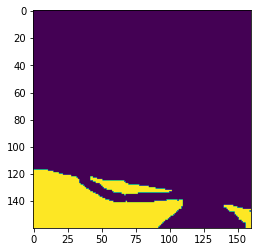

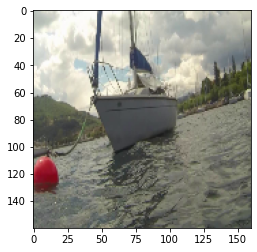

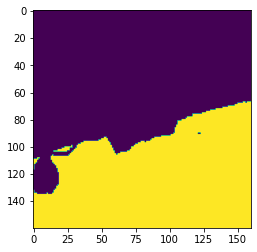

In [5]:
for i, image, label in zip(range(20),x,y):
    if i==20: break
    Dataset.plot_image(image)
    Dataset.plot_binary_image(label)

In [6]:
from losses import *
model_class= Models()
input_shape = (img_h, img_w, 3)
nb_classes = n_labels

        #Mobile net v2 medium
model7= model_class.get_unet_model_7(input_shape, nb_classes, dice_coef_loss, ['binary_crossentropy','mse','mae',  dice_coef])
model7.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 160, 160, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 160, 160, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [7]:

model6= model_class.get_unet_model_4(input_shape, nb_classes, dice_coef_loss, ['binary_crossentropy','mse','mae',  dice_coef])
model6.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 160, 160, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 160, 160, 32) 128         conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 160, 160, 32) 0           batch_normalization_4[0][0]      
_______________________________________________________________________________________

In [8]:
from losses import *

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

losses=[dice_coef_loss]#['binary_crossentropy', 'mse','mae', dice_coef_loss]
losses_name=['dice_coef_loss']#['binary_crossentropy', 'mse', 'mae', 'dice_coef_loss']
metrics=['binary_crossentropy','mse','mae',  dice_coef]

In [ ]:
batch_size=32
epochs=80
input_shape = (img_h, img_w, 3)
nb_classes = n_labels

model_class= Models()
path= 'models_saved/'

for name_loss, loss in zip(losses_name,losses):

    model1= model_class.get_unet_model_1(input_shape, nb_classes, loss, metrics)
    model2= model_class.get_unet_model_2(input_shape, nb_classes, loss, metrics)
    model3= model_class.get_unet_model_3(input_shape, nb_classes, loss, metrics)
    model4= model_class.get_unet_model_4(input_shape, nb_classes, loss, metrics)
    model5= model_class.get_unet_model_5(input_shape, nb_classes, loss, metrics)
    model6= model_class.get_unet_model_6(input_shape, nb_classes, loss, metrics)
    model7= model_class.get_unet_model_7(input_shape, nb_classes, loss, metrics)

    models= [model1, model2, model3, model4, model5, model6, model7]
    models_name= ['small', 'smallBN', 'medium', 'mediumBN', 'large', 'largeBN', 'largeMobileNet']
    
    for name_model, model in zip(models_name, models):
        
        model_name=path+model_base_name+name_model+'--'+name_loss
        
        model_checkpoint = ModelCheckpoint(model_name, monitor='val_loss', save_best_only=True)
        earlyStopping= EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=10,verbose=0, mode='min')
        
        history = model.fit(x=np.float32(x),y=np.float32(y),batch_size=batch_size,epochs=epochs,verbose=1,callbacks=[model_checkpoint, earlyStopping],validation_data=(np.float32(x_val), np.float32(y_val)),shuffle=True )
        model_class.save_history(path+model_base_name+'history--'+name_model+'--'+name_loss, history)
        
    model.save(path+'test.h5')

Epoch 1/80
147/147 [==============================] - ETA: 0s - loss: 0.4566 - binary_crossentropy: 0.6948 - mse: 0.2507 - mae: 0.4983 - dice_coef: 0.5434WARNING:tensorflow:From /home/naoki/.local/lib/python3.8/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models_saved/unet160--small--dice_coef_loss/assets
147/147 [==============================] - 464s 3s/step - loss: 0.4566 - binary_crossentropy: 0.6948 - mse: 0.2507 - mae: 0.4983 - dice_coef: 0.5434 - val_loss: 0.4435 - val_binary_crossentropy: 0.7416 - val_mse: 0.2723 - val_mae: 0.5081 - val_dice_coef: 0.5546
Epoch 2/80
147/147

Epoch 16/80
147/147 [==============================] - 430s 3s/step - loss: 0.1451 - binary_crossentropy: 1.1659 - mse: 0.1550 - mae: 0.1696 - dice_coef: 0.8549 - val_loss: 0.0627 - val_binary_crossentropy: 0.3662 - val_mse: 0.0576 - val_mae: 0.0668 - val_dice_coef: 0.9348
Epoch 17/80
147/147 [==============================] - 429s 3s/step - loss: 0.1359 - binary_crossentropy: 1.1937 - mse: 0.1458 - mae: 0.1580 - dice_coef: 0.8641 - val_loss: 0.0576 - val_binary_crossentropy: 0.3750 - val_mse: 0.0537 - val_mae: 0.0612 - val_dice_coef: 0.9403
Epoch 18/80
147/147 [==============================] - 452s 3s/step - loss: 0.1289 - binary_crossentropy: 1.2239 - mse: 0.1389 - mae: 0.1495 - dice_coef: 0.8711 - val_loss: 0.0553 - val_binary_crossentropy: 0.3938 - val_mse: 0.0527 - val_mae: 0.0598 - val_dice_coef: 0.9445
Epoch 19/80
147/147 [==============================] - 424s 3s/step - loss: 0.1252 - binary_crossentropy: 1.2585 - mse: 0.1355 - mae: 0.1451 - dice_coef: 0.8748 - val_loss: 0.062

Epoch 37/80
147/147 [==============================] - 429s 3s/step - loss: 0.0933 - binary_crossentropy: 1.2290 - mse: 0.1002 - mae: 0.1058 - dice_coef: 0.9067 - val_loss: 0.0415 - val_binary_crossentropy: 0.5083 - val_mse: 0.0414 - val_mae: 0.0449 - val_dice_coef: 0.9557
Epoch 38/80
147/147 [==============================] - 430s 3s/step - loss: 0.0929 - binary_crossentropy: 1.2294 - mse: 0.0997 - mae: 0.1052 - dice_coef: 0.9071 - val_loss: 0.0386 - val_binary_crossentropy: 0.4589 - val_mse: 0.0378 - val_mae: 0.0412 - val_dice_coef: 0.9572
Epoch 39/80
147/147 [==============================] - 429s 3s/step - loss: 0.0913 - binary_crossentropy: 1.2128 - mse: 0.0978 - mae: 0.1033 - dice_coef: 0.9087 - val_loss: 0.0395 - val_binary_crossentropy: 0.4309 - val_mse: 0.0379 - val_mae: 0.0416 - val_dice_coef: 0.9553
Epoch 40/80
147/147 [==============================] - 430s 3s/step - loss: 0.0906 - binary_crossentropy: 1.2096 - mse: 0.0967 - mae: 0.1021 - dice_coef: 0.9094 - val_loss: 0.038

Epoch 62/80
147/147 [==============================] - 427s 3s/step - loss: 0.0703 - binary_crossentropy: 1.1846 - mse: 0.0738 - mae: 0.0780 - dice_coef: 0.9297 - val_loss: 0.0334 - val_binary_crossentropy: 0.5532 - val_mse: 0.0339 - val_mae: 0.0360 - val_dice_coef: 0.9631
Epoch 63/80
147/147 [==============================] - 428s 3s/step - loss: 0.0712 - binary_crossentropy: 1.2063 - mse: 0.0748 - mae: 0.0790 - dice_coef: 0.9288 - val_loss: 0.0324 - val_binary_crossentropy: 0.4762 - val_mse: 0.0321 - val_mae: 0.0342 - val_dice_coef: 0.9636
Epoch 64/80
147/147 [==============================] - 427s 3s/step - loss: 0.0690 - binary_crossentropy: 1.1867 - mse: 0.0726 - mae: 0.0767 - dice_coef: 0.9310 - val_loss: 0.0341 - val_binary_crossentropy: 0.4931 - val_mse: 0.0337 - val_mae: 0.0360 - val_dice_coef: 0.9615
Epoch 65/80
147/147 [==============================] - 428s 3s/step - loss: 0.0679 - binary_crossentropy: 1.1745 - mse: 0.0711 - mae: 0.0752 - dice_coef: 0.9321 - val_loss: 0.032

147/147 [==============================] - 487s 3s/step - loss: 0.1883 - binary_crossentropy: 0.3298 - mse: 0.0993 - mae: 0.2094 - dice_coef: 0.8117 - val_loss: 0.1735 - val_binary_crossentropy: 0.3427 - val_mse: 0.1057 - val_mae: 0.2051 - val_dice_coef: 0.8231
Epoch 4/80
147/147 [==============================] - 486s 3s/step - loss: 0.1538 - binary_crossentropy: 0.2680 - mse: 0.0786 - mae: 0.1701 - dice_coef: 0.8462 - val_loss: 0.1001 - val_binary_crossentropy: 0.1492 - val_mse: 0.0379 - val_mae: 0.1061 - val_dice_coef: 0.8948
Epoch 5/80
147/147 [==============================] - 487s 3s/step - loss: 0.1348 - binary_crossentropy: 0.2371 - mse: 0.0686 - mae: 0.1490 - dice_coef: 0.8652 - val_loss: 0.0837 - val_binary_crossentropy: 0.1168 - val_mse: 0.0264 - val_mae: 0.0875 - val_dice_coef: 0.9130
Epoch 6/80
147/147 [==============================] - 488s 3s/step - loss: 0.1219 - binary_crossentropy: 0.2177 - mse: 0.0622 - mae: 0.1346 - dice_coef: 0.8781 - val_loss: 0.0767 - val_binary_

In [ ]:
# PRUEBAS NADA MAS A PARTIR DE ACA NO TOCAR (^ . ^ )
import numpy as np
import cv2
path ='/home/karina/PINV15177/Training/ter1.png'
img = cv2.imread(path)
img = np.uint16(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.imshow('image',img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
ima = cv2.imread('/home/karina/PINV15177/Training/ter1_mask.png')
ima = np.uint8(ima)
img = cv2.cvtColor(ima, cv2.COLOR_BGR2RGB)
cv2.imshow('image',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.imshow(img)

